In [2]:
import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import community as community_louvain  # Python-Louvain package



In [ ]:
dataset = Planetoid(root='data', name='Cora')
data = dataset[0]

# Convert to NetworkX graph (without weights for now)
G = to_networkx(data, to_undirected=True)

# Get node feature matrix
X = data.x.numpy()


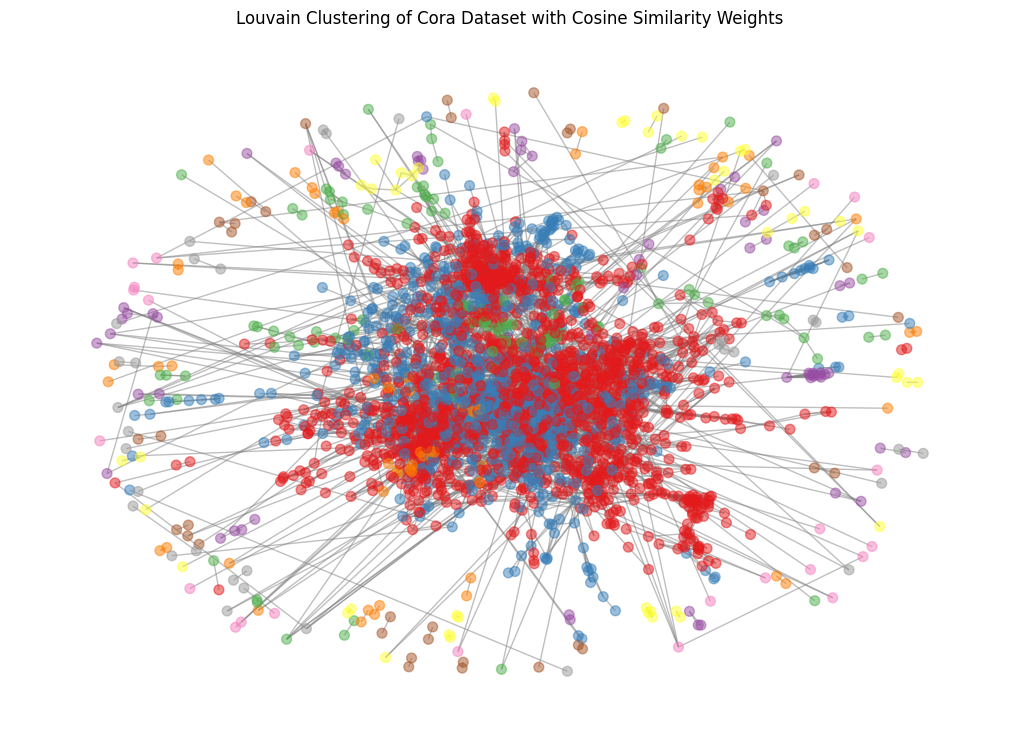

In [18]:
# Apply Louvain clustering
partition = community_louvain.best_partition(G)

# Visualize the clusters
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G, seed=42)  # Layout for visualization
colors = [partition[node] for node in G.nodes()]
nx.draw(G, pos, node_color=colors, cmap=plt.cm.Set1, node_size=50, edge_color='gray', alpha=0.5)
plt.title("Louvain Clustering of Cora Dataset with Cosine Similarity Weights")
plt.show()


In [19]:
print(len(partition))


2708


In [20]:
num_clusters = len(set(partition.values()))
print(f"Number of detected communities: {num_clusters}")


Number of detected communities: 210


In [25]:
modularity = community_louvain.modularity(partition, G)
print(f"Modularity score: {modularity:.4f}")


Modularity score: 0.8800


In [26]:
import community as community_louvain

# Generate the hierarchical dendrogram
dendrogram = community_louvain.generate_dendrogram(G)

# Number of hierarchical levels
print(f"Number of hierarchical levels: {len(dendrogram)}")


Number of hierarchical levels: 4


In [27]:
# Print community assignments at each level
for level in range(len(dendrogram)):
    partition_at_level = community_louvain.partition_at_level(dendrogram, level)
    print(f"Level {level}: {len(set(partition_at_level.values()))} communities")


Level 0: 693 communities
Level 1: 266 communities
Level 2: 213 communities
Level 3: 212 communities


In [28]:
import numpy as np
import community as community_louvain

# Define embedding dimension
d = 128  
k = 0.5  # Scaling factor

# Generate hierarchical clustering
dendrogram = community_louvain.generate_dendrogram(G, weight='weight')
num_levels = len(dendrogram)

# Assign a random d-dimensional vector to each cluster at every level
cluster_embeddings = {}
for level in range(num_levels):
    partition_at_level = community_louvain.partition_at_level(dendrogram, level)
    unique_clusters = set(partition_at_level.values())
    
    # Assign a random vector to each cluster
    cluster_embeddings[level] = {
        cluster_id: np.random.randn(d) for cluster_id in unique_clusters
    }


In [31]:
import torch
import numpy as np

# Get the original feature matrix
X = data.x.numpy()

# Number of original features and target feature dimension
num_features = X.shape[1]
target_dim = 128

# Generate unique random vectors for each feature (values between -1 and 1)
feature_map = np.random.uniform(-1, 1, (num_features, target_dim))

# Compute new feature vectors by summing corresponding unique vectors
X_transformed = X @ feature_map  # Matrix multiplication

# Normalize the feature vectors
X_transformed /= np.linalg.norm(X_transformed, axis=1, keepdims=True)

# Convert back to tensor if needed
X_transformed = torch.tensor(X_transformed, dtype=torch.float32)

# Print shape to verify
print(X_transformed.shape)  # Should be (num_nodes, 256)


torch.Size([2708, 128])


In [34]:
node_embeddings = {}

for node in G.nodes():
    embedding = np.zeros(d)  # Start with zero vector
    
    for level in range(num_levels):
        partition_at_level = community_louvain.partition_at_level(dendrogram, level)
        cluster_id = partition_at_level[node]  # Get cluster of node at this level
        embedding += (k ** (level + 1)) * cluster_embeddings[level][cluster_id]  # Weighted sum
        
    embedding += np.array(X_transformed[node].detach().cpu())
    
    node_embeddings[node] = embedding


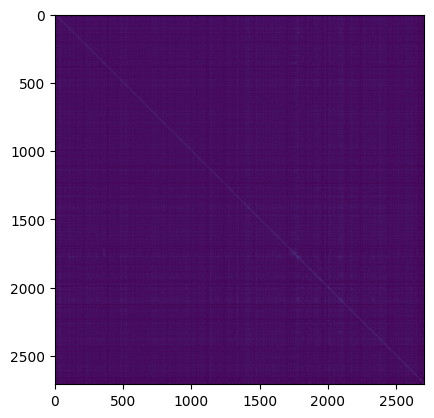

In [11]:
plt.imshow(data.x@data.x.T)

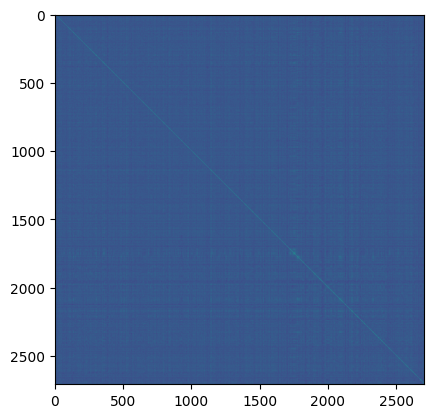

In [7]:
plt.imshow(X_transformed@X_transformed.T)